In [4]:
import numpy as np

from __future__ import print_function
import numpy as np
from ortools.sat.python import cp_model

import sys
import keras
from keras import Sequential
from keras import backend as bck
from keras.datasets import mnist

Using TensorFlow backend.


# Solver Class
This class contains a simple solver written in Or-Tools. Constraint programming used in here is very fast and (i hope) easy to understand.

Constructor contains data about sudoku - grid size, cell size and two or-tools objects:
- model
- solver
Both of those are used to find the solution. There is no need for more complicated solver than a basic CpSolver.

- get_values - reads grid given to class (read from image) and inserting to solution.
- printer - just a print-to-console class.
- solve() - ...solving. Contains proper constraints for sudoku.

In [5]:
# I am a simple solver.
class Solver:
    def __init__(self):
        self.model = cp_model.CpModel()
        self.solver = cp_model.CpSolver()
        self.grid_size = 9
        self.cell_size = 3

    def get_values(self, solution, original_grid):
        for row in range(self.grid_size):
            for column in range(self.grid_size):
                if original_grid[row, column] == 0:
                    solution[row, column] = self.model.NewIntVar(1, 9, '(%i,%i)' % (row, column))
                else:
                    solution[row, column] = self.model.NewConstant(int(original_grid[row, column]))
        return solution

    def printer(self, solution):
        for i in range(self.grid_size):
            if i % 3 == 0:
                print("\n")
            for j in range(self.grid_size):
                if j % 3 == 0 and j != 0:
                    print(" ", end = " ")
                print(self.solver.Value(solution[i,j]), end=" ")
            print()

    def solve(self, grid):
        solutions = {}

        # Get ints from grid
        solutions = self.get_values(solutions, grid)

        ##---CONSTRAINTS---
        # Horizontals
        for row in range(self.grid_size):
            line_horizontal = []
            for column in range(self.grid_size):
                line_horizontal.append(solutions[row, column])
            self.model.AddAllDifferent(line_horizontal)

        # Verticals
        for column in range(self.grid_size):
            line_vertical = []
            for row in range(self.grid_size):
                line_vertical.append(solutions[row, column])
            self.model.AddAllDifferent(line_vertical)

        # Squares
        for row_idx in range(0, self.grid_size, self.cell_size):
            for col_idx in range(0, self.grid_size, self.cell_size):
                self.model.AddAllDifferent([solutions[row_idx + row, column] for column in range(col_idx, (col_idx + self.cell_size)) 
                                            for row in range(self.cell_size)])

        # Solve model
        status = self.solver.Solve(self.model)
        if status != cp_model.INFEASIBLE:
            self.printer(solutions)
        else:
            print("Impossible to solve, try again.")


## Training
The class below is handling MNIST dataset and image adjustments, not much more to say.

In [6]:
# I am a training reader.
import cv2
class TrainingReader:
    def __init__(self):
        self.num_classes = 10
        self.size_rows = 28
        self.size_cols = 28
        self.input_shape = ()
        self.x_test = []
        self.x_train = []
        self.y_test = []
        self.y_train = []

    def adjust_images(self, x_train, x_test):
        # Shape adjustment
        x_train = np.reshape(x_train, (-1,28,28,1))
        x_test = np.reshape(x_test ,(-1,28,28,1))
        # Type adjustment
        x_train = x_train / 16
        x_test = x_test / 16
        return x_train, x_test

    def create_labels(self, y_original):
        y_new = keras.utils.to_categorical(y_original)
        return y_new

    def read_mnist(self):
        try:
            (x_train, y_train), (x_test, y_test) = mnist.load_data()
            self.x_train, self.x_test = self.adjust_images(x_train, x_test)
            self.y_train = self.create_labels(y_train)
            self.y_test = self.create_labels(y_test)
            print("MNIST dataset was read correctly!")
        except:
            print("Unexpected error in TrainingReader: ", sys.exc_info()[0])
            raise
        

# Model class
Model was created according to this article: https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist

In [7]:
from sklearn import svm
import sys
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

trainer = TrainingReader()
trainer.read_mnist()

MNIST dataset was read correctly!


In [8]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

model = Sequential()

model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        25632     
_________________________________________________________________
batch_normalization_3 (Batch (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)       

In [9]:
model.fit(trainer.x_train, trainer.y_train, batch_size=32, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 227s 4ms/step - loss: 0.1860 - accuracy: 0.9433
Epoch 2/10
60000/60000 [==============================] - 207s 3ms/step - loss: 0.0675 - accuracy: 0.9796
Epoch 3/10
60000/60000 [==============================] - 201s 3ms/step - loss: 0.0569 - accuracy: 0.9829
Epoch 4/10
60000/60000 [==============================] - 184s 3ms/step - loss: 0.0471 - accuracy: 0.9860
Epoch 5/10
60000/60000 [==============================] - 189s 3ms/step - loss: 0.0426 - accuracy: 0.9874
Epoch 6/10
60000/60000 [==============================] - 202s 3ms/step - loss: 0.0356 - accuracy: 0.9890
Epoch 7/10
60000/60000 [==============================] - 204s 3ms/step - loss: 0.0330 - accuracy: 0.9895
Epoch 8/10
60000/60000 [==============================] - 202s 3ms/step - loss: 0.0304 - accuracy: 0.99091s - los
Epoch 9/10
60000/60000 [==============================] - 196s 3ms/step - loss: 0.0286 - accuracy: 0.9915
Epoch 10/10
60000/60000 [=============

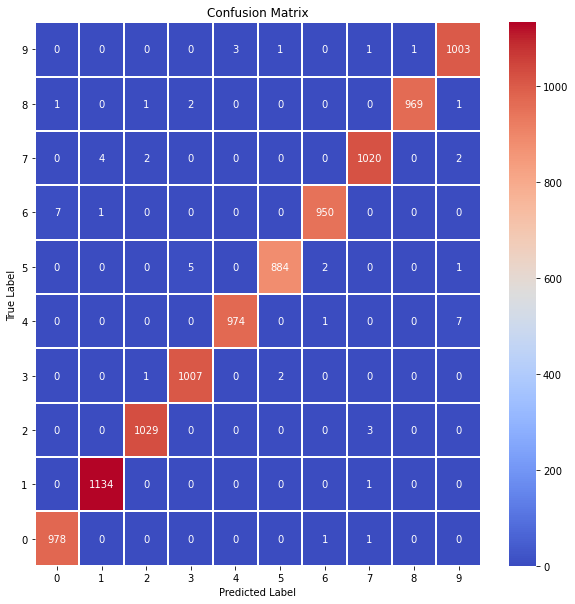

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       0.99      1.00      1.00      1010
           4       1.00      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       1.00      0.99      1.00       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sb

def show_confusion_matrix(validations, predictions, num_classes):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(num_classes, num_classes))
    hm = sb.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=[0,1,2,3,4,5,6,7,8,9],
                yticklabels=[0,1,2,3,4,5,6,7,8,9],
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)
    hm.invert_yaxis()
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

x_test = model.predict(trainer.x_test)

max_x_test = np.argmax(x_test, axis=1)
max_y_test = np.argmax(trainer.y_test, axis=1)

show_confusion_matrix(max_y_test, max_x_test, 10)

print(classification_report(max_y_test, max_x_test))

# Reading Lines from Pictures

## Image Reading
ImageReadder class's  purpose is to open the given image and search for lines inside. It uses Canny and HoughLines method from OpenCV.
- read_lines - reads the image and searches for lines.
- show_lines - adds lines to lists (horizontal/vertical) and allows to show the image with lines found.

In [10]:
import cv2
import numpy as np

class ImageReader:
    def __init__(self, image):
        self.lines = []
        self.original_img = cv2.imread(image)
        self.lines_img = cv2.imread(image)
        self.horizontal = []
        self.vertical = []
        
    def read_lines(self):
        gray = cv2.cvtColor(self.original_img, cv2.COLOR_BGR2GRAY)
        canny = cv2.Canny(gray, 50, 150, apertureSize = 3)
        self.lines = cv2.HoughLines(canny, 1, np.pi/180, 200)
            
    def show_lines(self):
        for line in self.lines:
            rho,theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            self.vertical.append([(x1, y1), (x2, y2)]) if theta == 0 else self.horizontal.append([(x1, y1), (x2, y2)])
            cv2.line(self.lines_img, (x1,y1),(x2,y2),(0,0,255),2)
        cv2.imshow('Lines read', self.lines_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        

In [11]:
img_read = ImageReader('example.png')
img_read.read_lines()
img_read.show_lines()

## Digits Predicting
DigitPrediction is a class that reads each cell and predicts the cell's digit. It's goal is to return a correct sudoku. 
- update_sudoku - simple method which updates the saved sudoku.
- get_reader_data - takes all important information from image reader (lines and image).
- read_cell - checks every cell for number and adds the adjusted image with coordinates to lists.
- digit_prediction - predicts the numbers according to previous readings
- correctness_handler - separates predictions into high/low probability. The low probability will be replaced if user wishes to.
- final_info - asks the user about reading. If it's incorrect, allows to change the number on given coordinate.
- predict_digits - main method summarizing all class.

In [36]:
class DigitPrediction:
    def __init__(self, image_reader):
        self.sudoku = np.zeros((81))
        # readings
        self.image_reader = image_reader
        self.sudoku_images = []
        self.rows = []
        # predictions
        self.prediction_probability = []
        self.prediction_value = []
        
    def update_sudoku(self, values):
        np.put(self.sudoku, [i[0]*9 + i[1] for i in self.rows], values)
        self.sudoku = np.reshape(self.sudoku, (9,9))
    
    def get_reader_data(self):
        print("\nReading data from image_reader...")
        lines = self.image_reader.lines
        horizontal = self.image_reader.horizontal
        vertical = self.image_reader.vertical
        image = self.image_reader.original_img
        horizontal.sort()
        vertical.sort()
        print("Horizontal size: {0}, Vertical size: {1}.".format(len(horizontal), len(vertical)))
        return lines, horizontal, vertical, image
    
    def read_cell(self):
        print("\nReading cells images...")
        lines, horizontal, vertical, image = self.get_reader_data()
        size_margin = int(image.shape[0]/100)
        lines_margin = 1+len(vertical)%9

        for i in range(0, len(vertical)-lines_margin):
            for j in range(0, len(horizontal)-lines_margin):
                if j % 2 == 0 and i % 2 == 0:
                    x1 = horizontal[i][0][1] + size_margin
                    y1 = vertical[j][0][0] + size_margin
                    x2 = horizontal[i+lines_margin][0][1] - size_margin
                    y2 = vertical[j+lines_margin][0][0] - size_margin
                    crop_img = image[x1:x2, y1:y2]
                    gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
                    negative = cv2.bitwise_not(gray)
                    if np.any(negative > 14):
                        resized = cv2.resize(negative, (28,28), interpolation = cv2.INTER_AREA) 
                        reshaped = np.reshape(resized, (28,28,1))
                        final = reshaped / 16
                        self.sudoku_images.append(final)
                        self.rows.append([int(i/2),int(j/2)])
        print("Digits found: ", len(self.sudoku_images))
                        
    def digit_prediction(self, model):
        print("\nPredicting values...")
        self.prediction_probability = model.predict(np.asarray(self.sudoku_images))
        self.prediction_value = model.predict_classes(np.asarray(self.sudoku_images))
        print("Predicted values: \n", self.prediction_value)
        
    def correctness_handler(self):
        print("\nChecking the predictions probabilities...")
        high_probabilities = []
        low_probabilities = []

        for i in range(len(self.prediction_value)):
            if self.prediction_probability[i][self.prediction_value[i]] > 0.7:
                high_probabilities.append(self.prediction_value[i])
            else:
                high_probabilities.append(0)
                low_probabilities.append(i)
            if len(low_probabilities) > 9:
                print("THE IMAGE WAS NOT READ CORRECTLY, TRY AGAIN!")
                raise
        print("Nice! I got {} digits with over 70% probability.".format(len(high_probabilities)))
        print("I got {} digits with smol probability.".format(len(low_probabilities)))
        return high_probabilities, low_probabilities
                
    def final_info(self, high_probabilities, low_probabilities):
        print("\nThis is what I've read. Is it a correct sudoku?\n Answer 'yes' if it's correct\n", self.sudoku)
        answer = input()
        if answer != "yes":
            amount = 0 
            while amount < len(low_probabilities):
                print("Some cells were uncertain. Please tell me - what is the number in cell? {}"
                      .format(self.rows[low_probabilities[amount]]))
                new_number = input()
                high_probabilities[low_probabilities[amount]] = new_number
                amount = amount + 1
            print("Final version:")
            self.update_sudoku(high_probabilities)
            print(self.sudoku)
            
    def predict_digits(self, model):
        try:
            self.read_cell()
            self.digit_prediction(model)
            high_probabilities, low_probabilities = self.correctness_handler()
            self.update_sudoku(high_probabilities)
            self.final_info(high_probabilities, low_probabilities)
        except:
            print("Unexpected error in DigitReader: ", sys.exc_info()[0])
            raise

# Main
Let's solve it!

In [38]:
if __name__ == "__main__":
    # Solver
    sudoku_solver = Solver()
    
    digit_predictor = DigitPrediction(img_read)
    digit_predictor.predict_digits(model)
    
    print("\nSolving the sudoku...\n")
    sudoku_solver.solve(digit_predictor.sudoku)



Reading cells images...

Reading data from image_reader...
Horizontal size: 18, Vertical size: 18.
Digits found:  29

Predicting values...
Predicted values: 
 [3 7 6 6 7 3 5 4 6 8 1 2 9 9 8 3 2 7 9 8 6 8 6 9 3 5 2 6 9]

Checking the predictions probabilities...
Nice! I got 29 digits with over 70% probability.
I got 2 digits with smol probability.

This is what I've read. Is it a correct sudoku?
 Answer 'yes' if it's correct
 [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0. 0. 0. 6. 0.]
 [0. 6. 7. 0. 3. 5. 0. 0. 4.]
 [6. 0. 8. 0. 2. 0. 9. 0. 0.]
 [0. 9. 0. 0. 8. 0. 0. 3. 0.]
 [0. 0. 2. 0. 7. 9. 8. 0. 6.]
 [8. 0. 0. 6. 9. 0. 3. 5. 0.]
 [0. 2. 6. 0. 0. 0. 0. 9. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
no
Some cells were uncertain. Please tell me - what is the number in cell? [1, 6]
1
Some cells were uncertain. Please tell me - what is the number in cell? [3, 3]
1
Final version:
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0. 0. 1. 6. 0.]
 [0. 6. 7. 0. 3. 5. 0. 0. 4.]
 [6. 0. 8. 1. 2. 0. 9. 0. 0.]